In [1]:
import torch
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
import numpy as np
from tqdm.notebook import tqdm

In [2]:
class tuple_to_dict:
    
    def __init__(self, tuple_object):
        self.tuple = tuple_object
    
    def __len__(self):
        return len(self.tuple)
    
    def __getitem__(self, index):
        return {
            "input" : self.tuple[index][0],
            "target" : self.tuple[index][1],
        }

In [3]:
def get_mnist(train=False):
    from torchvision import datasets, transforms
    return tuple_to_dict(datasets.MNIST("./resources/data/raw", train=train, transform=transforms.Compose([transforms.Grayscale(num_output_channels=3),transforms.Resize([32, 32]), transforms.ToTensor()])))

In [4]:
class mnist_m:
    
    def __init__(self, path, train=False):
        
        if train:
            self.files = open(path+"/mnist_m_train_labels.txt").read().split("\n")[:-1]
            self.path = path + "/mnist_m_train/"
        else:
            self.files = open(path+"/mnist_m_test_labels.txt").read().split("\n")[:-1]
            self.path = path + "/mnist_m_test/"
        
        print("Fetching {} files".format(len(self.files)))
        
        self.data = []
        for e in self.files:
            ee = e.split(" ")
            self.data.append({
                "input" : ee[0],
                "target" : int(ee[1])
            })
        
        self.transform = transforms.Compose([transforms.ToTensor()])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = Image.open(self.path + self.data[index]['input'])
        
        return {
            "input" : self.transform(image),
            "target" : self.data[index]['target']
        }

In [5]:
dataset = {
    "train" :{
        "mnist" : torch.utils.data.DataLoader(get_mnist(train=True), batch_size=64, drop_last=True),
        "mnist_m" : torch.utils.data.DataLoader(mnist_m("resources/data/raw/mnist_m/", train=True), batch_size=64,drop_last=True),
    },
    "test" : {
        "mnist" : torch.utils.data.DataLoader(get_mnist(train=False), batch_size=64,drop_last=True),
        "mnist_m" : torch.utils.data.DataLoader(mnist_m("resources/data/raw/mnist_m/", train=False), batch_size=64, drop_last=True),
    }
}

Fetching 59001 files
Fetching 9001 files


In [6]:
class grl_grad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return input

    @staticmethod
    def backward(ctx, grad_output):
        return -1*grad_output



class grl(torch.nn.Module):
    
    def __init__(self):
        super(grl, self).__init__()
    
    def forward(self, x):
        return grl_grad.apply(x)

In [7]:
class model(torch.nn.Module):        
    
    def __encoder__(self):
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=5, in_channels=3, out_channels=32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(kernel_size=5, in_channels=32, out_channels=48),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
    
    def __classifier__(self):
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.encoder_shape, out_features=100),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=100, out_features=100),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=100, out_features=10),
        )
    
    def __domain__(self):
        self.domain =  torch.nn.Sequential(
            torch.nn.Linear(in_features=self.encoder_shape, out_features=100),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=100, out_features=1),
        )
    
    
    def __init__(self,):
        super(model, self).__init__()
        self.encoder_shape = 48*5*5   
        self.__encoder__()
        self.__classifier__()
        self.grl = grl()
        self.__domain__()
    
    
    def forward(self, x, split=False):
        encoded = self.encoder(x).reshape([-1, self.encoder_shape])
        batch_size = encoded.shape[0]
        start_index = 0
        end_index = batch_size// 2
        
        if split:
            start_index = end_index
            end_index= batch_size
        
        return {
                "classifier" : self.classifier(encoded[start_index:end_index]),
                "domain" : self.domain(self.grl(encoded)).squeeze(-1)
            }
    
    def predict(self, x):
        encoded = self.encoder(x).reshape([-1, self.encoder_shape])
        
        return self.classifier(encoded)
               
        

In [8]:
def write_stats(stats, model, step):
    trainer.tensorboard_writer.add_scalar("loss/epoch/{}".format(model), np.mean(stats['loss']), step)
    trainer.tensorboard_writer.add_scalar("acc/epoch/{}/domain".format(model), np.mean(stats['acc']['domain']), step)
    trainer.tensorboard_writer.add_scalar("acc/epoch/{}/classifier".format(model), np.mean(stats['acc']['classifier']), step)

In [24]:
class train:
    
    def __init__(self, model_to_train):
        self.model = model_to_train()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
        self.model.to(self.device)
        self.loss = {
            "logistic" : torch.nn.BCEWithLogitsLoss(),
            "softmax" : torch.nn.CrossEntropyLoss(),
        }
        self.optimizer = torch.optim.SGD(lr=0.01, momentum=0.9, params=self.model.parameters())
#         self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lambda step:0.01/((1+step/100)**0.75), last_epoch=-1)
        self.step = 0
        self.__get_tensorboard()
    
    def loop(self, X, to_cpu=False):
        X = X.to(self.device)
        if to_cpu:
            return self.model(X).detach()
        return self.model(X)
    
    def compute_loss(self, X, output):
        lam = (2/(1+np.exp(-1*self.step/10))) - 1
        loss = self.loss['softmax'](target=X['target']['classifier'], input=output['classifier'])
#         loss += lam*self.loss['logistic'](target=X['target']['domain'], input=output['domain'])
        return loss
    
    def stats(self, X):
        output = self.loop(X['input'])
        loss = self.compute_loss(X, output)
        classifier_acc = np.count_nonzero(torch.nn.functional.softmax(output['classifier'], dim=-1).argmax(-1).cpu().numpy() == X['target']['classifier'].cpu().numpy())/len(X['target']['classifier'])
        target_out = self.model(X['input'], split=True)
        domain_acc = np.count_nonzero(torch.nn.functional.softmax(target_out['classifier'], dim=-1).argmax(-1).cpu().numpy() == X['target']['domain_classifier'].cpu().numpy())/len(X['target']['domain_classifier'])
        
        return {
            "acc" : {
                "classifier" : classifier_acc,
                "domain" : domain_acc,
            },
            "loss" : loss.item()
        }
    
    def cycle(self, X):
        self.optimizer.zero_grad()
        output = self.loop(X['input'])
        cur_loss = self.compute_loss(X, output)
        cur_loss.backward()
        self.optimizer.step()
#         self.scheduler.step()
        return cur_loss
    
    
    def get_X(self, mnist_batch, mnist_m_batch):
        
        mnist_batch_size = mnist_batch['input'].shape[0]
        mnist_m_batch_size = mnist_m_batch['input'].shape[0]
        
        return {
            "input" : torch.cat([mnist_batch['input'], mnist_m_batch['input']], axis=0).to(self.device),
            "target" : {
                "classifier" : mnist_batch['target'].to(self.device),
                "domain" : torch.cat([torch.ones(mnist_batch_size), torch.zeros(mnist_m_batch_size)], axis=0).to(self.device),
                "domain_classifier" : mnist_m_batch['target'].to(self.device)
            }
        }

    def batch(self, mnist_batch, mnist_m_batch, task):
        
        X = self.get_X(mnist_batch, mnist_m_batch)        
        if task:
            return self.cycle(X)
        else:
            return self.stats(X)
    
    def __get_tensorboard(self):
        from torch.utils.tensorboard import SummaryWriter
        from datetime import datetime

        task_type = "MNIST"
        time_date = "{}".format(datetime.now())
        self.tensorboard_writer = SummaryWriter("log/{}/{}".format(task_type, time_date))

In [25]:
trainer = train(model)

In [26]:
best_acc = 0
for epoch in tqdm(range(1000)):
    
    mnist_m_iter = dataset['train']['mnist_m'].__iter__()
    for mnist_batch in dataset['train']['mnist']:
        
        mnist_m_batch = next(mnist_m_iter, None)
        if mnist_m_batch is None:
            mnist_m_iter = dataset['train']['mnist_m'].__iter__()
            mnist_m_batch = next(mnist_m_iter, None)
            
        loss = trainer.batch(mnist_batch, mnist_m_batch, True)
        trainer.tensorboard_writer.add_scalar("loss/batch/train", loss.item())
    trainer.step+=1
    
    stats = {
        "loss":[],
        "acc" : {
            "domain":[],
            "classifier":[]
        }
    }
    mnist_m_iter = dataset['train']['mnist_m'].__iter__()
    for mnist_batch in dataset['train']['mnist']:
        
        mnist_m_batch = next(mnist_m_iter, None)
        if mnist_m_batch is None:
            mnist_m_iter = dataset['train']['mnist_m'].__iter__()
            mnist_m_batch = next(mnist_m_iter, None)        
        
        batch_stats = trainer.batch(mnist_batch, mnist_m_batch, False)
        stats['loss'].append(batch_stats['loss'])
        stats['acc']['domain'].append(batch_stats['acc']['domain'])
        stats['acc']['classifier'].append(batch_stats['acc']['classifier'])
    
    write_stats(stats, "train", epoch)
    
    stats = {
        "loss":[],
        "acc" : {
            "domain":[],
            "classifier":[]
        }
    }
    mnist_m_iter = dataset['test']['mnist_m'].__iter__()
    for mnist_batch in dataset['test']['mnist']:
        
        mnist_m_batch = next(mnist_m_iter, None)
        if mnist_m_batch is None:
            mnist_m_iter = dataset['test']['mnist_m'].__iter__()
            mnist_m_batch = next(mnist_m_iter, None)        
        
        batch_stats = trainer.batch(mnist_batch, mnist_m_batch, False)
        stats['loss'].append(batch_stats['loss'])
        stats['acc']['domain'].append(batch_stats['acc']['domain'])
        stats['acc']['classifier'].append(batch_stats['acc']['classifier'])
    
    write_stats(stats, "test", epoch)
    
    
#     if np.mean(stats['acc']['domain']) > best_acc:
#         torch.save(trainer.model.state_dict(), "./weights/model_{}".format(epoch))
        
print('Finished Training')

KeyboardInterrupt: 

In [40]:
trainer.model.load_state_dict(torch.load("./weights/model_172"))

<All keys matched successfully>

In [27]:
encoder_output = []
k = 0
for e in tqdm(dataset['test']['mnist']):
    encoder_output.append(trainer.model.encoder(e['input'].to(trainer.device)).detach().cpu().numpy())
    if k>10:
        break
    k+=1
k = 0
for e in tqdm(dataset['test']['mnist_m']):
    encoder_output.append(trainer.model.encoder(e['input'].to(trainer.device)).detach().cpu().numpy())
    if k>10:
        break
    k+=1

In [28]:
encoder_output = np.concatenate(encoder_output, axis=0).reshape([-1, 48*5*5])

In [15]:
from sklearn.manifold import TSNE

In [29]:
tsne = TSNE()

In [30]:
plots = tsne.fit_transform(encoder_output)

In [31]:
y = np.arange(len(plots))

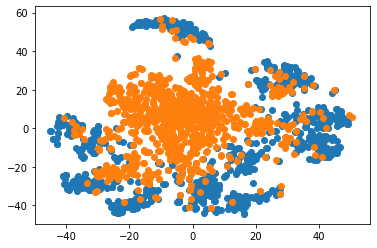

In [32]:
plt.scatter(plots[y<768][:,0], plots[y<768][:,1])
plt.scatter(plots[y>=768][:,0], plots[y>=768][:,1])

In [59]:
plots.shape

(896, 2)

In [284]:
X = trainer.get_X(mnist_batch, mnist_m_batch)

In [297]:
output = trainer.loop(X['input'])

In [308]:
torch.nn.functional.softmax(output['classifier'], dim=-1).argmax(-1).cpu().numpy() == X['target']['classifier'].cpu().numpy()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False])

In [293]:
X['target']['domain_classifier']

tensor([0, 4, 4, 0, 9, 3, 5, 8, 9, 7, 4, 5, 4, 8, 3, 2, 7, 1, 3, 7, 9, 3, 2, 5,
        4, 5, 2, 9, 7, 1, 4, 2, 7, 1, 6, 3, 9, 8, 3, 6, 4, 4, 1, 9, 6, 4, 3, 9,
        1, 2, 9, 0, 7, 0, 0, 4, 8, 4, 3, 6, 3, 2, 6, 5], device='cuda:0')

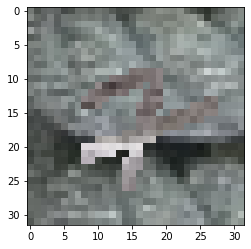

In [295]:
plt.imshow(X['input'][65].transpose(0, 2).cpu())

In [344]:
lam = (2/(1+np.exp(-1*0/100))) - 1

In [345]:
lam

0.0